<a href="https://colab.research.google.com/github/Data-philic/Fake-News-Detection/blob/main/ALL_Main_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb

GridsearchCV: https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb

Main code:
https://github.com/rockash/Fake-news-Detection

**Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from textblob import TextBlob #for polarity and subjectivity
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Mounting to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### Loading Data

In [ ]:
true_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv')
fake_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv')

#Adding column 'label' 1: fake and 0: real
true_df['label']=0
fake_df['label']=1

#concatinating required columns from both datasets into data
data=pd.concat([true_df[['text','label']],fake_df[['text','label']]], ignore_index=True)
data

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,1
44894,21st Century Wire says It s a familiar theme. ...,1
44895,Patrick Henningsen 21st Century WireRemember ...,1
44896,21st Century Wire says Al Jazeera America will...,1


subject
politicsNews    11272
worldnews       10145
Name: text, dtype: int64


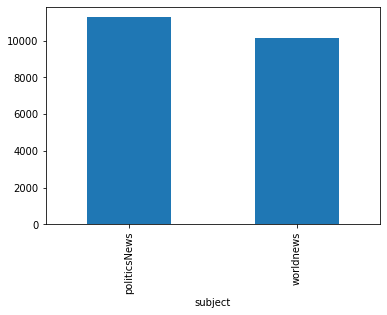

In [ ]:
#Visualization of News per subject in real news
print(true_df.groupby(['subject'])['text'].count())
true_df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

subject
Government News    1570
Middle-east         778
News               9050
US_News             783
left-news          4459
politics           6841
Name: text, dtype: int64


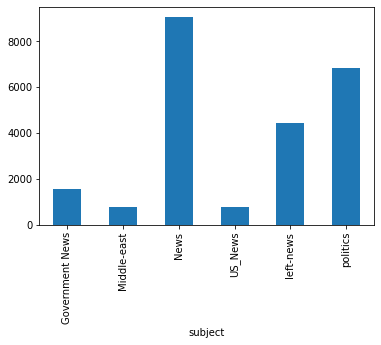

In [ ]:
#Visualization of News per subject in fake news
print(fake_df.groupby(['subject'])['text'].count())
fake_df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
0    21417
1    23481
Name: text, dtype: int64


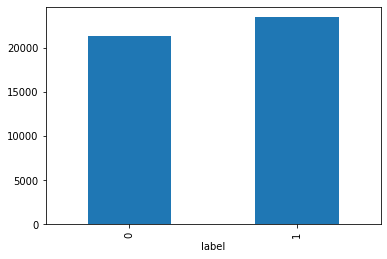

In [ ]:
#Number of fake(1) and real(0) news
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

There are more fake news than real news in the taken dataset, but there isn't much difference.

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def cleanup(text): 
    text = re.sub(r"[^A-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [lemmatizer.lemmatize(w, pos='v') for w in text if not w in stops]
    text = " ".join(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

def constructTaggedDocument(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(word_tokenize(row), ['Text' + '_%s' % str(index)]))
    return sentences

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    vec = [model.infer_vector(doc.words, steps=20) for doc in sents]
    return vec

- If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
- 300- dimensional feature vectors.
- min_count=2, ignores all words with total frequency lower than this.
- negative=5 , specifies how many “noise words” should be drawn.
- hs=0 , and negative is non-zero, negative sampling will be used.
- sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
- workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [ ]:
def data_prep(data, vector_dimension=300):
    #remove missing rows
    data=data[data['text'].notnull()].reset_index()
    #Text pre-processing
    data['text']=data['text'].apply(cleanup)
    #train-test Split 70/30
    train, test = train_test_split(data, test_size=0.3, random_state=42, stratify = data['label'])
    train_tagged = constructTaggedDocument(train['text'])
    test_tagged = constructTaggedDocument(test['text'])
    #Building Vocabolary `dm=1`, 'distributed memory' (PV-DM)
    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=multiprocessing.cpu_count(), epochs=10, seed=1)
    text_model.build_vocab(train_tagged)
    text_model.train(train_tagged, total_examples=text_model.corpus_count, epochs=text_model.epochs)

    X_train = np.array(vec_for_learning(text_model, train_tagged))
    X_test = np.array(vec_for_learning(text_model, test_tagged))
    analysisPol_train = np.array(train['text'].apply(lambda sentence: TextBlob(sentence).polarity))
    analysisSub_train = np.array(train['text'].apply(lambda sentence: TextBlob(sentence).subjectivity))
    analysisPol_test = np.array(test['text'].apply(lambda sentence: TextBlob(sentence).polarity))
    analysisSub_test = np.array(test['text'].apply(lambda sentence: TextBlob(sentence).subjectivity))
    X_train = np.column_stack((X_train, analysisPol_train, analysisSub_train))
    X_test = np.column_stack((X_test, analysisPol_test, analysisSub_test))

    y_train = train['label'].values
    y_test = test['label'].values
    return X_train, X_test, y_train, y_test

In [ ]:
xtr,xte,ytr,yte = data_prep(data,400)
np.save('/content/drive/MyDrive/Colab Notebooks/xtr', xtr)
np.save('/content/drive/MyDrive/Colab Notebooks/xte', xte)
np.save('/content/drive/MyDrive/Colab Notebooks/ytr', ytr)
np.save('/content/drive/MyDrive/Colab Notebooks/yte', yte)

In [ ]:
xtr = np.load('/content/drive/MyDrive/Colab Notebooks/xtr.npy')
xte = np.load('/content/drive/MyDrive/Colab Notebooks/xte.npy')
ytr = np.load('/content/drive/MyDrive/Colab Notebooks/ytr.npy')
yte = np.load('/content/drive/MyDrive/Colab Notebooks/yte.npy')

In [ ]:
xtr.shape

### Supporting functions

In [ ]:
pip install scikit-plot

In [ ]:
import scikitplot.plotters as skplt
from sklearn import metrics

#get a confusion metrics
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()
    
def model_performance(y_test, y_pred):
    rec={"Accuracy":round(metrics.accuracy_score(y_test, y_pred),3),"Percision":round(metrics.precision_score(y_test, y_pred),3),"Recall":round(metrics.recall_score(y_test, y_pred),3),"F1-score":round(metrics.f1_score(y_test, y_pred),3)}
    for score in rec.items():
        print("{} of the model: {}".format(score[0], score[1]))
    return(rec.values())

## Models

### Non-Ensemble Models:
1. Logistic Regression, 
2. SVM, 
3. Linear SVM, 
4. KNN, 
5. GaussianNB, 
7. PassiveAggressiveClassifier

### Ensemble Models
Bagging:
1. RandomForestClassifier, 

Voting:
1. VotingClassifier: (RF, LR, KNN), 

Boosting: 
1. Adaboost, 
2. XGboost, 
3. GradientBoostingClassifier

### Logistic Regression

Accuracy of the model: 0.944
Percision of the model: 0.943
Recall of the model: 0.951
F1-score of the model: 0.947


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


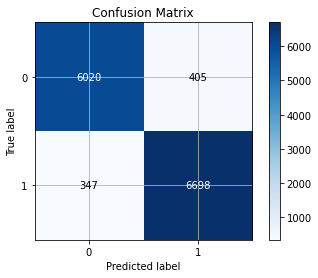

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=200)
logreg.fit(xtr,ytr)
y_pred=logreg.predict(xte)
bfr_metrics = model_performance(yte, y_pred) #list of scores before Hyperparameter Tunning
plot_cmat(yte, y_pred)

In [ ]:
#Hyperparameter Tuning
# define the grid of values to search
grid = {'penalty':["l1","l2"], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'C': [100, 10, 1.0, 0.1, 0.01]}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(LogisticRegression(max_iter=200), grid, n_jobs=-1, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  clf.best_estimator_
  i+=1

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best: 0.944285 using {'solver': 'saga', 'penalty': 'l1', 'C': 100}
Best: 0.944731 using {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best: 0.944826 using {'solver': 'sag', 'penalty': 'l2', 'C': 10}
Best: 0.945017 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}
Best: 0.945017 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}


In [ ]:
# define the grid of values to search
grid = {'solver': ['lbfgs', 'sag'],
        'C': np.arange(.1,20,0.5)}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(LogisticRegression(max_iter=200, penalty="l2"), grid, n_jobs=-1, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  clf.best_estimator_
  i+=1

In [ ]:
clf = GridSearchCV(LogisticRegression(max_iter=200, penalty="l2", solver = 'lbfgs'), {'C': np.arange(0.6,2.7,0.2)}, cv=10, return_train_score=False, n_jobs=-1)
clf.fit(xtr,ytr)
clf.best_estimator_

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=2.400000000000001, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logreg.fit(xtr,ytr)
y_pred=logreg.predict(xte)
aftr_metrics=model_performance(yte, y_pred) #list of scores after Hyperparameter Tunning
plot_cmat(yte, y_pred)

### SVM

Accuracy of the model: 0.961
Percision of the model: 0.96
Recall of the model: 0.967
F1-score of the model: 0.963


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


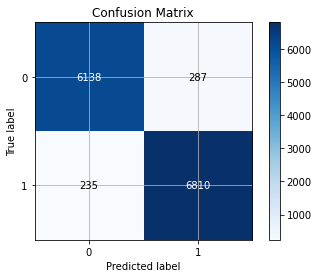

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svc = make_pipeline(StandardScaler(), SVC())
svc.fit(xtr, ytr)

y_pred = svc.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.967
Percision of the model: 0.962
Recall of the model: 0.975
F1-score of the model: 0.969


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


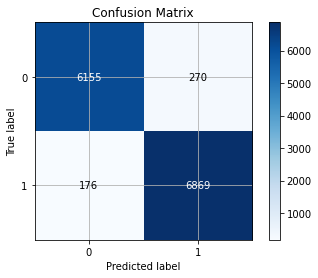

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=3))
svc.fit(xtr, ytr)

y_pred = svc.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

### Linear SVM

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy of the model: 0.943
Percision of the model: 0.939
Recall of the model: 0.953
F1-score of the model: 0.946


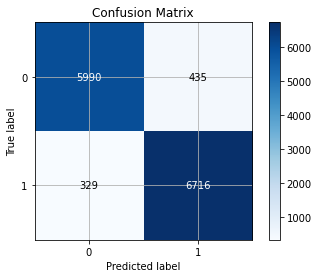

In [ ]:
from sklearn.svm import LinearSVC
Lsvm = LinearSVC()
Lsvm.fit(xtr, ytr)

y_pred = Lsvm.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

In [ ]:
 #Hyperparameter Tuning
# define the grid of values to search
grid = {'penalty':["l1","l2"],
        'C': [100, 10, 1.0, 0.1, 0.01]}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(LinearSVC(), grid, n_jobs=-1, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  i+=1

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best: 0.944413 using {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best: 0.944413 using {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best: 0.944444 using {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best: 0.944476 using {'penalty': 'l2', 'C': 1.0}
Best: 0.944413 using {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
grid = {'C': [5, 1.0, 0.5, 0.1, 0.05, 0.005, 0.001]}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(LinearSVC(penalty="l2"), grid, n_jobs=-1, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  i+=1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.944412 using {'C': 0.5}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.944412 using {'C': 0.5}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.944444 using {'C': 1.0}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.944381 using {'C': 0.5}
Best: 0.944444 using {'C': 0.5}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
clf = GridSearchCV(LinearSVC(penalty= 'l2'), { 'C': np.arange(0,1.1,.1)}, cv=10, return_train_score=False, n_jobs=-1)
clf.fit(xtr, ytr)
clf.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy of the model: 0.943
Percision of the model: 0.939
Recall of the model: 0.953
F1-score of the model: 0.946


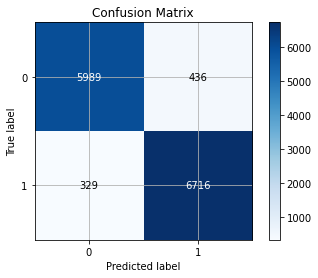

In [ ]:
Lsvm = LinearSVC(penalty= 'l2', C=1)
Lsvm.fit(xtr, ytr)
y_pred = Lsvm.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy of the model: 0.945
Percision of the model: 0.939
Recall of the model: 0.956
F1-score of the model: 0.947


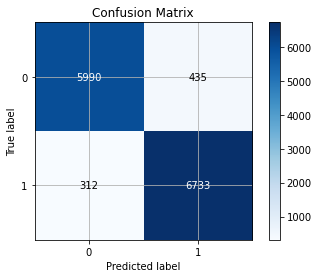

In [ ]:
from sklearn.svm import LinearSVC
Lsvm = LinearSVC(penalty= 'l2', C=.5)
Lsvm.fit(xtr, ytr)
y_pred = Lsvm.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

### KNN

Accuracy of the model: 0.807
Percision of the model: 0.848
Recall of the model: 0.77
F1-score of the model: 0.807


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


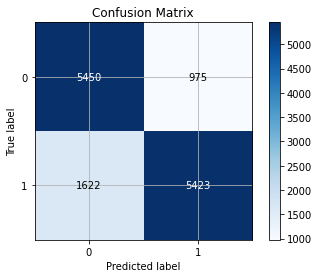

In [ ]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(xtr, ytr)
y_pred = knn.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.818
Percision of the model: 0.853
Recall of the model: 0.789
F1-score of the model: 0.82


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


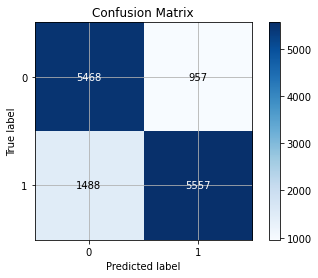

In [ ]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtr, ytr)
y_pred = knn.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.815
Percision of the model: 0.849
Recall of the model: 0.786
F1-score of the model: 0.816


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


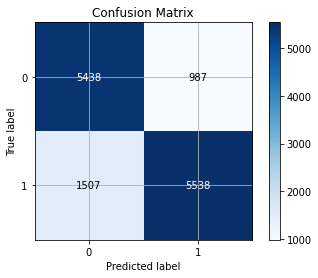

In [ ]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors=3, p=1)
knn.fit(xtr, ytr)
y_pred = knn.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.837
Percision of the model: 0.863
Recall of the model: 0.819
F1-score of the model: 0.84


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


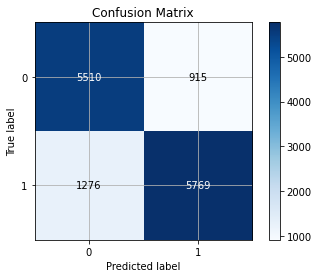

In [ ]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors=1, p=1)
knn.fit(xtr, ytr)
y_pred = knn.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.84
Percision of the model: 0.865
Recall of the model: 0.823
F1-score of the model: 0.844


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


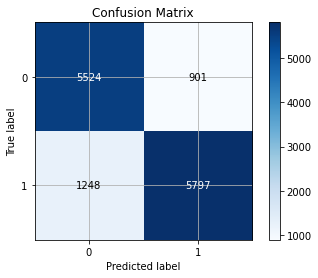

In [ ]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xtr, ytr)
y_pred = knn.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

### PassiveAggressiveClassifier

Accuracy of the model: 0.916
Percision of the model: 0.908
Recall of the model: 0.934
F1-score of the model: 0.921


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


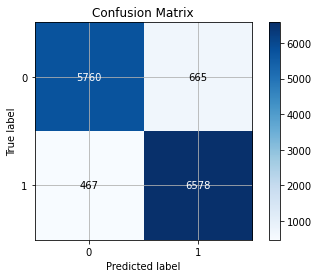

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
#Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(xtr,ytr)
y_pred=pac.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

In [ ]:
 #Hyperparameter Tuning
# define the grid of values to search
grid = {'C': [100, 10, 1.0, 0.1, 0.01, 0.001]}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(PassiveAggressiveClassifier(n_jobs=-1, random_state=5), grid, n_jobs=-1, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  i+=1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941231 using {'C': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941231 using {'C': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941231 using {'C': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941231 using {'C': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941231 using {'C': 0.01}


In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
grid = {'C': [0.1, 0.01, 0.001, 0.0001,0.00001,0.000001,0.000000001]}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(PassiveAggressiveClassifier(max_iter=50, n_jobs=-1, random_state=5), grid, n_jobs=-1, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  i+=1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941644 using {'C': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941644 using {'C': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941644 using {'C': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941644 using {'C': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.941644 using {'C': 0.0001}


In [ ]:
clf = GridSearchCV(PassiveAggressiveClassifier(max_iter=50, n_jobs=-1, random_state=5), { 'C': [0.00005, 0.0001, 0.00015]}, cv=10, return_train_score=False, n_jobs=-1)
clf.fit(xtr, ytr)
clf.best_estimator_

PassiveAggressiveClassifier(C=5e-05, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=-1, random_state=5, shuffle=True, tol=0.001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False)

Accuracy of the model: 0.946
Percision of the model: 0.949
Recall of the model: 0.947
F1-score of the model: 0.948


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


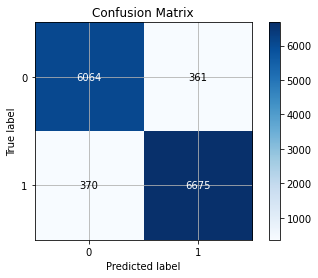

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(C=5e-05, max_iter=50, n_jobs=-1, random_state=5)
pac.fit(xtr,ytr)
y_pred=pac.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

### Bagging

#### RandomForestClassifier

Accuracy of the model: 0.941
Percision of the model: 0.937
Recall of the model: 0.951
F1-score of the model: 0.944


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


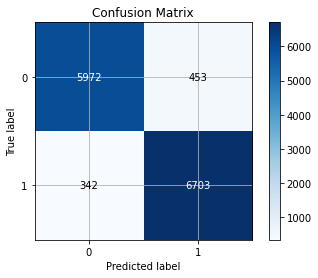

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=200,n_jobs=-1)
    
random_forest.fit(xtr,ytr)
y_pred=random_forest.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.943
Percision of the model: 0.938
Recall of the model: 0.954
F1-score of the model: 0.946


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


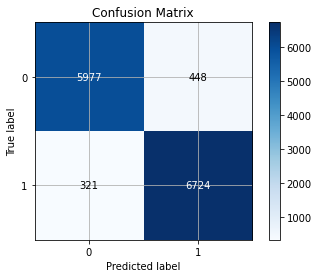

In [ ]:
#max_features=auto (sqrt(n_features))
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=800,n_jobs=-1)
    
random_forest.fit(xtr,ytr)
y_pred=random_forest.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.947
Percision of the model: 0.942
Recall of the model: 0.958
F1-score of the model: 0.95


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


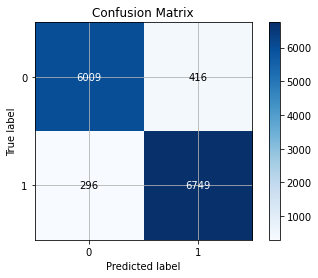

In [ ]:
#max_features='log2'
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=800,max_features='log2', n_jobs=-1)

random_forest.fit(xtr,ytr)
y_pred=random_forest.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

#### BaggingClassifier

Accuracy of the model: 0.883
Percision of the model: 0.902
Recall of the model: 0.87
F1-score of the model: 0.886


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


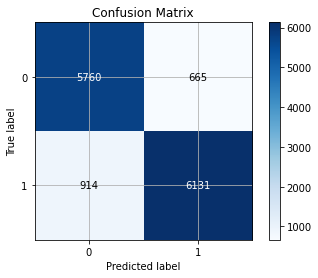

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier()
    
bag_clf.fit(xtr,ytr)
y_pred=bag_clf.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.912
Percision of the model: 0.908
Recall of the model: 0.925
F1-score of the model: 0.916


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


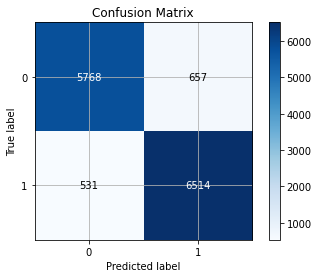

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(n_estimators=100)
    
bag_clf.fit(xtr,ytr)
y_pred=bag_clf.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

Accuracy of the model: 0.914
Percision of the model: 0.911
Recall of the model: 0.927
F1-score of the model: 0.919


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


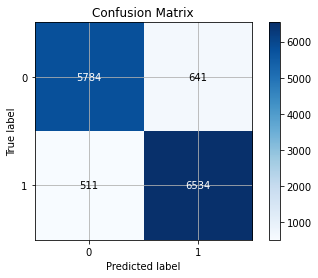

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(n_estimators=300)
    
bag_clf.fit(xtr,ytr)
y_pred=bag_clf.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(n_estimators=500)
    
bag_clf.fit(xtr,ytr)
y_pred=bag_clf.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

### VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

#### RF, LR, KNN

In [ ]:
VCmodel1 = VotingClassifier(estimators=[('RF', random_forest),('LR', logreg), ('KNN', knn)], voting='hard', n_jobs=-1)
VCmodel1.fit(xtr,ytr)
VCmodel1.score(xte,yte)

y_pred=VCmodel1.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

NameError: ignored

#### LR, SVC, LinearSVM

Accuracy of the model: 0.946
Percision of the model: 0.944
Recall of the model: 0.954
F1-score of the model: 0.949


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


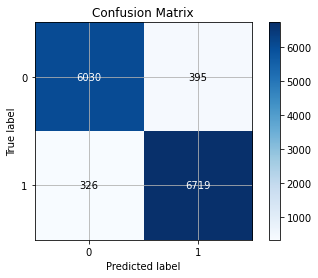

In [ ]:
VCmodel1 = VotingClassifier(estimators=[('LR', logreg), ('SVC', svc), ('LinearSVM', Lsvm)], voting='hard', n_jobs=-1)
VCmodel1.fit(xtr,ytr)

y_pred=VCmodel1.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

In [ ]:
VCmodel1 = VotingClassifier(estimators=[('LR', logreg), ('SVC', svc), ('LinearSVM', Lsvm)], voting='hard', n_jobs=-1)
VCmodel1.fit(xtr,ytr)

y_pred=VCmodel1.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

### Boosting

### AdaBoosting

Accuracy of the model: 0.906
Percision of the model: 0.905
Recall of the model: 0.917
F1-score of the model: 0.911


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


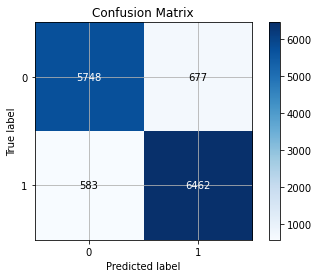

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
#(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)[source]
AdB_model = AdaBoostClassifier(random_state=1)
AdB_model.fit(xtr,ytr)
AdB_model.score(xte,yte)
y_pred=AdB_model.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
grid = {'n_estimators': [10, 50, 100, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}
i=0
while i < 5:
  # define the grid search procedure
  clf = RandomizedSearchCV(AdaBoostClassifier(), grid, cv= 10, scoring='accuracy')
  # execute the grid search
  grid_result=clf.fit(xtr,ytr)
  # summarize the best score and configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  i+=1

In [ ]:
#Hyperparameter Tuning
from sklearn.model_selection import RepeatedStratifiedKFold
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
clf = GridSearchCV(AdaBoostClassifier(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = clf.fit(xtr,ytr)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
clf.best_estimator_

### XGBoost

Accuracy of the model: 0.838
Percision of the model: 0.837
Recall of the model: 0.857
F1-score of the model: 0.847


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


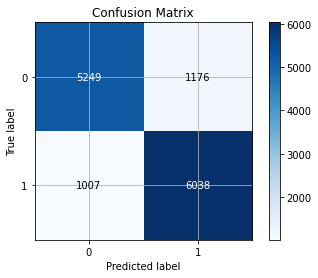

In [ ]:
import xgboost as xgb
Xgb_model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
Xgb_model.fit(xtr,ytr)
Xgb_model.score(xte,yte)
y_pred=Xgb_model.predict(xte)

model_performance(yte, y_pred)

plot_cmat(yte, y_pred)